# Posprocessing a run

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %env XLA_PYTHON_CLIENT_MEM_FRACTION=.6
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [3]:
import lenses
import jax
import numpy as np
from jax import numpy as jnp
from typing import cast
import matplotlib.pyplot as plt
from tqdm import trange

from flox.util import key_chain
from flox.flow import Pipe, Inverted, bind
from functools import partial
import equinox as eqx

from rigid_flows.flow import build_flow, RigidWithAuxiliary
from rigid_flows.data import Data, DataWithAuxiliary
from rigid_flows.density import OpenMMDensity
from rigid_flows.specs import ExperimentSpecification
from rigid_flows.utils import jit_and_cleanup_cache, scanned_vmap

2023-03-03 12:24:33.909949: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-03-03 12:24:33.910039: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-03-03 12:24:33.910046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
## pymbar changes jax default to float64, which is a problem https://github.com/choderalab/pymbar/blob/4afa42064c39658b7b7945808973b958e16f35f2/pymbar/mbar_solvers.py#L18
## here we load a modified pymbar
import pymbar

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


pymbar: force_no_jax = True


In [5]:
chain = key_chain(42)

def count_params(model):
    return jax.tree_util.tree_reduce(
        lambda s, n: s + n.size if eqx.is_array(n) else s,
        model,
        jnp.zeros((), dtype=jnp.int32),
    ).item()

In [6]:
# logdir_path = "../jonas_logdir/"

# logdir_path += 'tuna_N16_T100_noaux_2023-01-24_16:02:39' #ESS 22.12% internally coherent ------------------
# logdir_path += 'antelope_N16_T50_noaux_2023-01-25_08:08:54' #ESS 4.80% ------------------
# logdir_path += 'dragonfly_N128_T100_noaux_2023-01-24_22:33:59' #ESS 0.25% ------------------

#######################################################################################################

logdir_path = "../logdir/"
# logdir_path += 'tuna_N16_T50_2023-02-23_11:41:34'

folder = !ls -d {logdir_path}antelope_N128_T50_lr*
logdir_path = folder[-1]

#######################################################################################################

# logdir_path = "../testing"

#######################################################################################################

stage = !ls -d {logdir_path}/training_stage* |wc -l
stage = int(stage[0]) - 1
epoch = !ls -d {logdir_path}/training_stage_{stage}/epoch_* |wc -l
epoch = int(epoch[0]) - 1
print(f"+++ trainng stage {stage}, epoch {epoch} +++")
specs_path = f"{logdir_path}/config.yaml"
pretrained_model_path = f"{logdir_path}/training_stage_{stage}/epoch_{epoch}/model.eqx"
print(pretrained_model_path)

+++ trainng stage 0, epoch 9 +++
../logdir/antelope_N128_T50_lr_2023-03-02_16:13:38/training_stage_0/epoch_9/model.eqx


In [7]:
specs = ExperimentSpecification.load_from_file(specs_path)
specs = lenses.bind(specs).model.base.path.set(specs.model.base.path + "/eval_100")
num_eval_samples = 10_000
selection = np.s_[-num_eval_samples:]

base = OpenMMDensity.from_specs(specs.model.use_auxiliary, specs.model.base, selection)
target = OpenMMDensity.from_specs(specs.model.use_auxiliary, specs.model.target, selection)
model = base.omm_model.model

flow = build_flow(
    next(chain),
    specs.model.base.num_molecules,
    specs.model.use_auxiliary,
    specs.model.flow,
)
flow = cast(
    Pipe[DataWithAuxiliary, RigidWithAuxiliary],
    eqx.tree_deserialise_leaves(pretrained_model_path, flow),
)

training_data_size = 100_000 if specs.model.base.num_samples is None else specs.model.base.num_samples
print(f"tot flow parameters: {count_params(flow):_}")
print(f"MD training datapoints = {training_data_size:_}")
print(f"MD eval datapoints = {base.data.pos.shape[0]:_}")
print(f"batchs per epoch = {specs.train[0].num_iters_per_epoch}")
print(f"batch size = {specs.train[0].num_samples}")
print(f"data fraction: {specs.train[0].num_epochs*specs.train[0].num_samples*specs.train[0].num_iters_per_epoch/training_data_size}")

tot flow parameters: 7_458_896
MD training datapoints = 100_000
MD eval datapoints = 10_000
batchs per epoch = 2000
batch size = 32
data fraction: 6.4


In [8]:
try:
    ref_file = f"../data/water/DeltaF_estimates/DF-{specs.model.base}-{specs.model.target}.txt"
    reference_deltaF, reference_deltaF_std = np.loadtxt(ref_file, unpack=True)
except FileNotFoundError:
    reference_deltaF, reference_deltaF_std = None, None

reference_deltaF, reference_deltaF_std

(-14522.10556, 0.13929)

In [9]:
def ess(logw):
    return jnp.exp(
        2 * jax.scipy.special.logsumexp(logw) - jax.scipy.special.logsumexp(2 * logw)
    )


def plot_2Dview(
    data_tr: DataWithAuxiliary, title: str, toPBC: bool = True, skip: int = 10
):
    model.plot_2Dview(
        data_tr.obj.pos.reshape(-1, model.n_atoms, 3), toPBC=toPBC, title=title
    )


hist_kwargs = {"bins": "auto", "density": True, "alpha": 0.5}


def plot_results(
    deltaFs,
    reference_deltaF=reference_deltaF,
    reference_deltaF_std=reference_deltaF_std,
    LFEPdeltaFs=None,
    ESSs=None,
    num_samples=10_000,
    std_deltaFs=None,
    LFEPonly=False,
):
    if ESSs is not None and not LFEPonly:
        plt.plot(ESSs[:, 0] / num_samples * 100, "-o", label="forward")
        plt.plot(ESSs[:, 1] / num_samples * 100, "-o", label="inverse")
        plt.axhline(100 / num_samples, c="k", ls=":", label="ESS=1")
        plt.ylabel("ESS %")
        plt.legend()
        plt.show()
        print(f"average ESS: {ESSs[:,0].mean() / num_samples:.2%} +/- {ESSs[:,0].std() / num_samples:.2%}")

    xlim = [0, len(deltaFs)]
    n = 2  # how many sigmas for errorbar

    if LFEPdeltaFs is not None:
        if not LFEPonly:
            plt.plot(LFEPdeltaFs[:, 1], ".", c="blue", label="LFEP_target")
            x = 2 * [LFEPdeltaFs[:, 1].mean()]
            plt.fill_between(
                xlim,
                x - n * LFEPdeltaFs[:, 1].std(),
                x + n * LFEPdeltaFs[:, 1].std(),
                color="blue",
                alpha=0.3,
            )
            plt.axhline(LFEPdeltaFs[:, 1].mean(), c="blue")

        plt.plot(LFEPdeltaFs[:, 0], ".", c="green", label="LFEP_base")
        x = 2 * [LFEPdeltaFs[:, 0].mean()]
        plt.fill_between(
            xlim,
            x - n * LFEPdeltaFs[:, 0].std(),
            x + n * LFEPdeltaFs[:, 0].std(),
            color="green",
            alpha=0.3,
        )
        plt.axhline(LFEPdeltaFs[:, 0].mean(), c="green")

    if not LFEPonly:
        plt.plot(deltaFs, ".", c="orange", label="LBAR")
        x = 2 * [deltaFs.mean()]
        plt.fill_between(
            xlim, x - n * deltaFs.std(), x + n * deltaFs.std(), color="orange", alpha=0.3
        )
        plt.axhline(deltaFs.mean(), c="orange")

    if reference_deltaF is not None:
        plt.axhline(reference_deltaF, c="k", ls=":", label="MBAR reference")
        x = np.array(2 * [reference_deltaF])
        plt.fill_between(
            xlim,
            x - n * reference_deltaF_std,
            x + n * reference_deltaF_std,
            color="k",
            alpha=0.1,
        )
    plt.xlim(xlim)
    plt.legend()
    plt.show()

In [10]:
sc = model.n_molecules
n_sigmas = 2

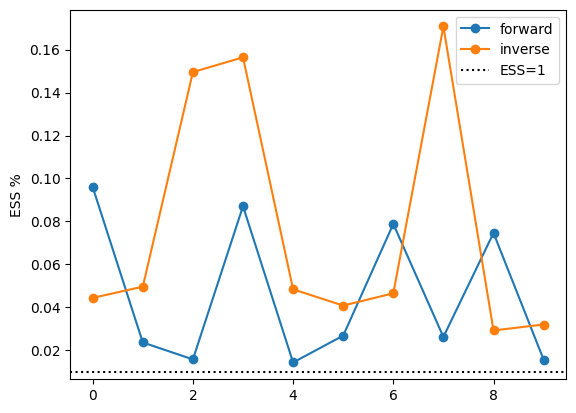

average ESS: 0.05% +/- 0.03%


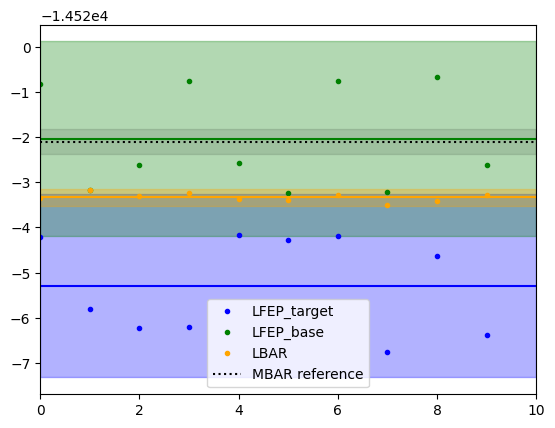

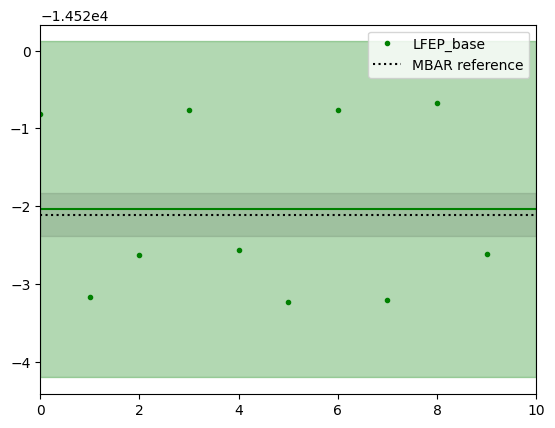

DeltaF_LBAR      = -113.463527 +/- 0.00144679
DeltaF_LFEP_base = -113.453440 +/- 0.0168497
DeltaF_ref       = -113.453950 +/- 0.00217641


SystemError: LBARstats found, sure you want to recalculate them?

In [11]:
filename = f'{logdir_path}/training_stage_{stage}/epoch_{epoch}/LBARstats'
stats_found = False
try: 
    stats = np.load(filename+'.npz')
    stats_found = True
except FileNotFoundError:
    print('no LBARstats found')

if stats_found:
    plot_results(**stats)
    plot_results(**stats, LFEPonly=True)
    print(f"DeltaF_LBAR      = {stats['deltaFs'].mean()/sc:.6f} +/- {n_sigmas*stats['deltaFs'].std()/sc:g}")
    print(f"DeltaF_LFEP_base = {stats['LFEPdeltaFs'][:,0].mean()/sc:.6f} +/- {n_sigmas*stats['LFEPdeltaFs'][:,0].std()/sc:g}")
    print(f"DeltaF_ref       = {reference_deltaF/sc:.6f} +/- {n_sigmas*reference_deltaF_std/sc:g}")
    raise SystemError('LBARstats found, sure you want to recalculate them?')

In [ ]:
batch_size = 1000
def jitvmap(fn, batch_size=batch_size):
    if batch_size is None:
        return jax.jit(jax.vmap(fn))
    else:
        return jax.jit(scanned_vmap(fn, batch_size))

In [ ]:
num_samples = 10_000

print('sampling base')
keys = jax.random.split(next(chain), num_samples)
base_tr = jitvmap(base.sample)(keys)

print('mapping')
mapped_tr = jitvmap(flow.forward)(base_tr.obj)

print('getting logw')
logw = base_tr.ldj + mapped_tr.ldj - jitvmap(target.potential)(mapped_tr.obj)

plt.hist(jnp.exp(logw-logw.max()), bins=100)
plt.yscale('log')
plt.show()

print(f'ESS = {ess(logw):g}  ->  {ess(logw)/len(logw):.2%}')


In [ ]:
print('sampling target')
keys = jax.random.split(next(chain), num_samples)
target_tr = jitvmap(target.sample)(keys)

print('mapping')
back_mapped_tr = jitvmap(flow.inverse)(target_tr.obj)

print('getting logw')
## NB: base_tr.ldj = jax.vmap(base.potential)(base_tr.obj)
back_logw = target_tr.ldj + back_mapped_tr.ldj - jitvmap(base.potential)(back_mapped_tr.obj)

plt.hist(jnp.exp(back_logw - back_logw.max()), bins=100)
plt.yscale('log')
plt.show()

print(f'ESS = {ess(back_logw):g}  ->  {ess(back_logw)/len(back_logw):.2%}')

In [ ]:
plot_2Dview(base_tr, title='base')
plot_2Dview(back_mapped_tr, title='back_mapped')

plot_2Dview(target_tr, title='target')
plot_2Dview(mapped_tr, title='mapped')

In [ ]:
ene_label = 'omm'
scaling = 1
if ene_label == 'omm':
    scaling = target.omm_model.kbT
base_ene2 = target.compute_energies(base_tr.obj, True, False, True)[ene_label] * scaling
target_ene2 = target.compute_energies(target_tr.obj, True, False, True)[ene_label] * scaling
mapped_ene2 = target.compute_energies(mapped_tr.obj, True, False, True)[ene_label] * scaling
back_mapped_ene2 = target.compute_energies(back_mapped_tr.obj, True, False, True)[ene_label] * scaling

In [ ]:
plt.hist(base_ene2, **hist_kwargs, label='base')
plt.hist(mapped_ene2, **hist_kwargs, label='mapped', histtype='step')
plt.hist(target_ene2, **hist_kwargs, label='target')
plt.hist(back_mapped_ene2, **hist_kwargs, label='back_mapped', histtype='step')
# plt.hist(mapped_ene2, weights=jnp.exp(logw-jax.scipy.special.logsumexp(logw)), bins=75, histtype='step', density=True, label='reweighted')
plt.xlabel(ene_label + ' energy [kJ/mol]') #it's kJ/mol only for omm energies
plt.legend()
plt.show()

In [ ]:
## LFEP

deltaF = (jnp.log(len(logw)) - jax.scipy.special.logsumexp(logw)).item()
print(f'Estimated deltaF from base   (above) = {deltaF:g}')

back_deltaF = -(jnp.log(len(back_logw)) - jax.scipy.special.logsumexp(back_logw)).item()
print(f'Estimated deltaF from target (below) = {back_deltaF:g}')

if reference_deltaF is not None:
    print(f'               Reference MBAR deltaF = {reference_deltaF:g} +/- {reference_deltaF_std:g}')

In [ ]:
# raise SystemError('Stop here')

## compute LBAR

In [ ]:
N_k = np.array([mapped_tr.obj.pos.shape[0], back_mapped_tr.obj.pos.shape[0]])

u_kn = np.empty((2, N_k.sum()))
u_kn[0] = np.concatenate([target_tr.ldj, base_tr.ldj - logw])
u_kn[1] = np.concatenate([target_tr.ldj - back_logw, base_tr.ldj])

N_k.shape, u_kn.shape

In [ ]:
mbar = pymbar.MBAR(u_kn, N_k, n_bootstraps=200, solver_protocol='robust')
# mbar = pymbar.MBAR(u_kn, N_k, n_bootstraps=200, initial_f_k=u_kn.mean(axis=1))

In [ ]:
results = mbar.compute_free_energy_differences(uncertainty_method="bootstrap")

print(f"DeltaF = {results['Delta_f'][-1,0]} +/- {results['dDelta_f'][-1,0]:g}")

## estimate with uncertainty

In [ ]:
num_iterations = 10
num_samples = 10_000 #num_eval_samples // num_iterations
print(f'Runnig {num_iterations} iterations with {num_samples:_} samples, out of {num_eval_samples:_}')


N_k = np.array(2*[num_samples])
u_kn = np.zeros((2, 2*num_samples))

LFEPdeltaFs = np.zeros((num_iterations, 2))
deltaFs = np.zeros(num_iterations)
std_deltaFs = np.zeros(num_iterations)
ESSs = np.zeros((num_iterations, 2))
for i in range(num_iterations):# again, this only works on startup!
    print('\niter:', i)
    print('sampling base...', end='\r')
    keys = jax.random.split(next(chain), num_samples)
    base_tr = jitvmap(base.sample)(keys)
    mapped_tr = jitvmap(flow.forward)(base_tr.obj)
    logw = base_tr.ldj + mapped_tr.ldj - jitvmap(target.potential)(mapped_tr.obj)
    ESSs[i, 0] = ess(logw)
    LFEPdeltaFs[i,0] = (jnp.log(len(logw)) - jax.scipy.special.logsumexp(logw)).item()
    print(f'DeltaF = {LFEPdeltaFs[i,0]}, efficiency = {ESSs[i, 0]/len(logw):.2%}')
    
    print('sampling target...', end='\r')
    keys = jax.random.split(next(chain), num_samples)
    target_tr = jitvmap(target.sample)(keys)
    back_mapped_tr = jitvmap(flow.inverse)(target_tr.obj)
    back_logw = target_tr.ldj + back_mapped_tr.ldj - jitvmap(base.potential)(back_mapped_tr.obj)
    ESSs[i, 1] = ess(back_logw)
    LFEPdeltaFs[i,1] = -(jnp.log(len(back_logw)) - jax.scipy.special.logsumexp(back_logw)).item()
    print(f'DeltaF = {LFEPdeltaFs[i,1]}, efficiency = {ESSs[i, 1]/len(back_logw):.2%}')

    print('calc mbar...', end='\r')
    u_kn[0] = np.concatenate([target_tr.ldj, base_tr.ldj - logw])
    u_kn[1] = np.concatenate([target_tr.ldj - back_logw, base_tr.ldj])
    mbar = pymbar.MBAR(u_kn, N_k, n_bootstraps=100, solver_protocol='robust')
    results = mbar.compute_free_energy_differences(uncertainty_method="bootstrap")
    deltaFs[i] = results['Delta_f'][-1,0]
    std_deltaFs[i] = results['dDelta_f'][-1,0]
    print(f"DeltaF = {results['Delta_f'][-1,0]} +/- {results['dDelta_f'][-1,0]:g}")

In [ ]:
plot_results(deltaFs, reference_deltaF, reference_deltaF_std, LFEPdeltaFs, ESSs, num_samples)
plot_results(deltaFs, reference_deltaF, reference_deltaF_std, LFEPdeltaFs, None, num_samples, LFEPonly=True)
print(f"average ESS: {ESSs[:,0].mean() / num_samples:.2%} +/- {ESSs[:,0].std() / num_samples:.2%}")

In [ ]:
# filename = f'{logdir_path}/training_stage_{stage}/epoch_{epoch}/LBARstats'
np.savez(filename, ESSs=ESSs, LFEPdeltaFs=LFEPdeltaFs, deltaFs=deltaFs, std_deltaFs=std_deltaFs, num_samples=num_samples)